# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from google.colab import files

# **Data Wrangling**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/CapstoneProject/Online Retail.csv')

## Assessing Data

In [4]:
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [6]:
df.describe()

,index,Quantity,UnitPrice,CustomerID
count,541909.00000,541909.000000,541909.000000,406829.000000
mean,270954.00000,9.552250,4.611114,15287.690570
std,156435.79785,218.081158,96.759853,1713.600303
min,0.00000,-80995.000000,-11062.060000,12346.000000
25%,135477.00000,1.000000,1.250000,13953.000000
50%,270954.00000,3.000000,2.080000,15152.000000
75%,406431.00000,10.000000,4.130000,16791.000000
max,541908.00000,80995.000000,38970.000000,18287.000000


In [7]:
df.isna().sum()

,0
index,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Cleaning Data

In [8]:
df = df.dropna(subset=["Description"])
df = df.drop(columns=["CustomerID"])
df.isna().sum()

,0
index,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


# **Preprocessing**

In [11]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    typo_dict = {
        'tealight': 'tea light',
        'lantrn': 'lantern',
        'mugx': 'mug',
        'coathanger': 'coat hanger',
        'cakestand': 'cake stand',
        'doormatx': 'doormat',
        'noteboook': 'notebook',
        'baskset': 'basket',
        'bown': 'bowl',
        'shooper': 'shopper',
        'jumbobag': 'jumbo bag',
        'coffe': 'coffee'
    }
    for typo, correction in typo_dict.items():
        text = text.replace(typo, correction)
    return text

# **Exploratory Data Analysis (EDA)**

In [12]:
print(df.columns)

Index(['index', 'InvoiceNo', 'StockCode', 'item', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country'],
      dtype='object')


In [15]:
df = df.rename(columns={'Description': 'item'})
df['item'] = df['item'].apply(preprocess_text)

def format_rupiah(value):
    try:
        value = float(value)
        return f"Rp {int(value):,}".replace(",", ".")
    except:
        return "Rp 0"

df['HargaRupiah'] = df['UnitPrice'].apply(format_rupiah)

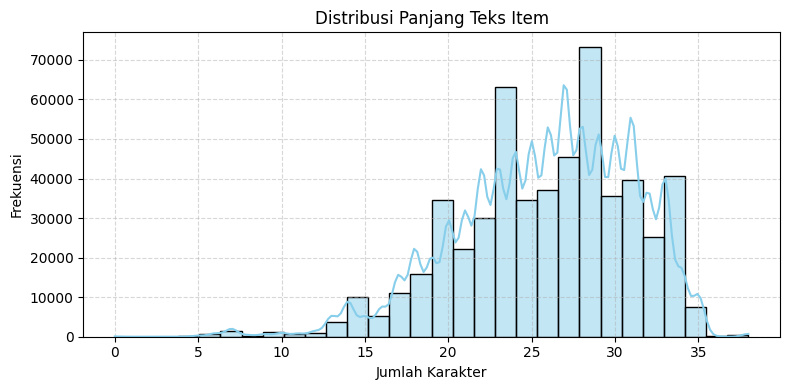

In [17]:
df['item_length'] = df['item'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(df['item_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks Item')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **Label Kategori Manual**

In [18]:
def assign_category_v3(item):
    item = str(item).lower()

    # Home Decor
    if any(keyword in item for keyword in [
        'lantern', 'light holder', 'frame', 'hook', 'cabinet', 'drawer',
        'coathanger', 'doormat', 'plant holder', 'chalkboard', 'mirror', 'clock',
        'baskets', 'decor', 'parasol', 'sign', 'drawer knob', 'wall art', 'black board',
        'metal heart', 'heart of wicker', 'metal birdcage', 'card holder', 'flower jug',
        'fire bucket', 'shelf', 'vase', 'home building block', 'love building block'
    ]):
        return 'Home Decor'

    # Kitchenware
    elif any(keyword in item for keyword in [
        'mug', 'cup', 'plate', 'cutlery', 'cake case', 'teaspoon', 'bottle',
        'milk jug', 'tea set', 'cake tin', 'jug', 'bowl', 'beaker', 'snack box',
        'lunch box', 'lunch bag', 'coaster', 'napkin', 'glass', 'baking tray',
        'popcorn holder', 'kitchen scales', 'cakestand', 'cake stand',
        'tea coffee sugar tins', 'bread bin'
    ]):
        return 'Kitchenware'

    # Toys & Games
    elif any(keyword in item for keyword in [
        'toy', 'jigsaw', 'puzzle', 'playhouse', 'sticker', 'doll', 'soft toy', 'game',
        'paint set', 'activity', 'mini jigsaw', 'snakes & ladders', 'craft', 'drawing',
        'coloring', 'play', 'alphabet', 'cards', 'spinning top', 'skittles'
    ]):
        return 'Toys & Games'

    # Stationery
    elif any(keyword in item for keyword in [
        'card', 'notebook', 'journal', 'pencil', 'pen', 'eraser', 'ruler', 'sharpener',
        'sticky note', 'memo', 'envelope', 'stationery', 'bookmark', 'shopping list'
    ]):
        return 'Stationery'

    # Seasonal & Gifts
    elif any(keyword in item for keyword in [
        'christmas', 'gift', 'present', 'xmas', 'bauble', 'stocking', 'cracker',
        'wrapping', 'hamper', 'valentine', 'easter', 'packaging', 'bunting', 'ribbon', 'party', 'retrospot'
    ]):
        return 'Seasonal & Gifts'

    # Lighting & Night Lights
    elif any(keyword in item for keyword in [
        'lamp', 'led', 'night light', 'light shade', 'light garland', 'candle', 'tealight', 'toadstool'
    ]):
        return 'Lighting & Night Lights'

    # Baking & Food Prep
    elif any(keyword in item for keyword in [
        'baking', 'cake stand', 'cake tin', 'baking set', 'jam making',
        'kitchen scales', 'measuring', 'rolling pin', 'bakeware'
    ]):
        return 'Baking & Food Prep'

    # Storage & Organisers
    elif any(keyword in item for keyword in [
        'box', 'organiser', 'storage', 'drawer', 'rack', 'basket', 'crate', 'chest'
    ]):
        return 'Storage & Organisers'

    # Fashion & Bags
    elif any(keyword in item for keyword in [
        'bag', 'shopper', 'shoulder bag', 'jumbo bag', 'handbag', 'coin purse', 'wallet', 'cash+carry'
    ]):
        return 'Fashion & Bags'

    # Garden & Outdoor
    elif any(keyword in item for keyword in [
        'garden', 'outdoor', 'kneeling pad', 'bird ornament', 'planter', 'parasol', 'flowerpot', 'gardeners'
    ]):
        return 'Garden & Outdoor'

    # Health & Personal Care
    elif any(keyword in item for keyword in [
        'plasters', 'tissues', 'hand warmer', 'sewing kit'
    ]):
        return 'Health & Personal Care'

    # Crafts & DIY
    elif any(keyword in item for keyword in [
        'knitting', 'doilies', 'silk fan'
    ]):
        return 'Crafts & DIY'

    # Baking Tools
    elif any(keyword in item for keyword in [
        'cookie cutter'
    ]):
        return 'Baking Tools'

    # Postage & Packaging
    elif any(keyword in item for keyword in [
        'postage', 'dotcom postage'
    ]):
        return 'Postage & Packaging'

    else:
        return 'Lainnya'

df['Category'] = df['item'].apply(assign_category_v3)
category_counts_v3 = df['Category'].value_counts()
category_counts_v3

,count
Category,
Home Decor,131924
Lainnya,105854
Kitchenware,95899
Seasonal & Gifts,57859
Toys & Games,32772
Stationery,29923
Fashion & Bags,22099
Storage & Organisers,20067
Lighting & Night Lights,13902


<ipython-input-19-256675739>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Category", order=df["Category"].value_counts().index, palette="Set2")


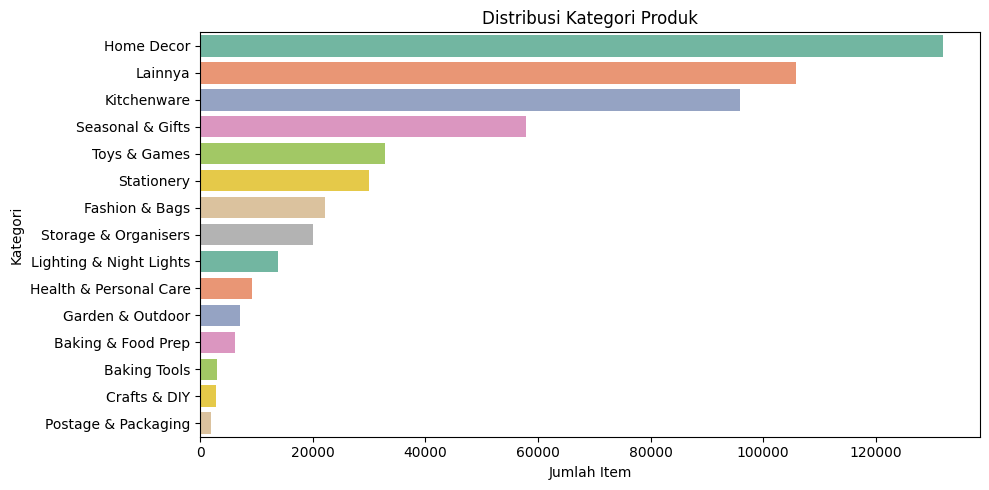

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y="Category", order=df["Category"].value_counts().index, palette="Set2")
plt.title("Distribusi Kategori Produk")
plt.xlabel("Jumlah Item")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()

## TF-IDF Vectorizer

In [20]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['item'])
y = df['Category']

## Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model Klasifikasi

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}

## Training dan Evaluasi


===== Logistic Regression =====
                         precision    recall  f1-score   support

     Baking & Food Prep       1.00      1.00      1.00      1222
           Baking Tools       1.00      1.00      1.00       605
           Crafts & DIY       1.00      1.00      1.00       560
         Fashion & Bags       1.00      1.00      1.00      4420
       Garden & Outdoor       1.00      1.00      1.00      1419
 Health & Personal Care       1.00      1.00      1.00      1834
             Home Decor       1.00      1.00      1.00     26385
            Kitchenware       1.00      1.00      1.00     19180
                Lainnya       0.99      1.00      1.00     21171
Lighting & Night Lights       1.00      0.99      1.00      2780
    Postage & Packaging       1.00      1.00      1.00       392
       Seasonal & Gifts       1.00      1.00      1.00     11572
             Stationery       1.00      0.99      1.00      5984
   Storage & Organisers       1.00      1.00      1.00  

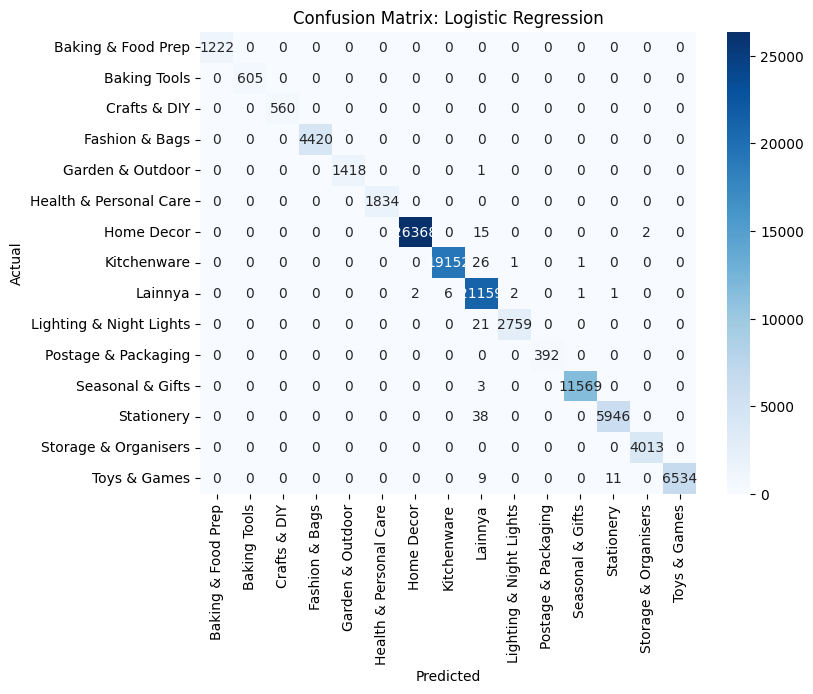


===== Random Forest =====
                         precision    recall  f1-score   support

     Baking & Food Prep       1.00      1.00      1.00      1222
           Baking Tools       1.00      1.00      1.00       605
           Crafts & DIY       1.00      1.00      1.00       560
         Fashion & Bags       1.00      1.00      1.00      4420
       Garden & Outdoor       1.00      1.00      1.00      1419
 Health & Personal Care       1.00      1.00      1.00      1834
             Home Decor       1.00      1.00      1.00     26385
            Kitchenware       1.00      1.00      1.00     19180
                Lainnya       1.00      1.00      1.00     21171
Lighting & Night Lights       1.00      1.00      1.00      2780
    Postage & Packaging       1.00      1.00      1.00       392
       Seasonal & Gifts       1.00      1.00      1.00     11572
             Stationery       1.00      1.00      1.00      5984
   Storage & Organisers       1.00      1.00      1.00      40

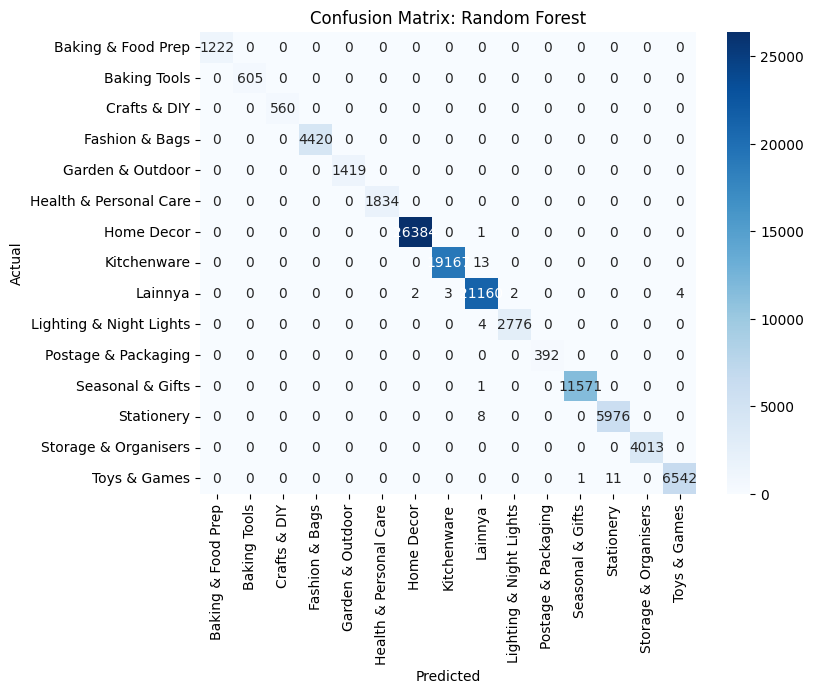


===== Naive Bayes =====
                         precision    recall  f1-score   support

     Baking & Food Prep       0.98      0.99      0.98      1222
           Baking Tools       1.00      1.00      1.00       605
           Crafts & DIY       1.00      1.00      1.00       560
         Fashion & Bags       0.99      0.98      0.98      4420
       Garden & Outdoor       1.00      1.00      1.00      1419
 Health & Personal Care       1.00      0.94      0.97      1834
             Home Decor       0.92      0.99      0.95     26385
            Kitchenware       0.96      0.97      0.97     19180
                Lainnya       0.97      0.87      0.92     21171
Lighting & Night Lights       0.96      0.95      0.95      2780
    Postage & Packaging       0.98      1.00      0.99       392
       Seasonal & Gifts       0.94      0.97      0.95     11572
             Stationery       0.99      0.97      0.98      5984
   Storage & Organisers       0.97      0.96      0.96      4013

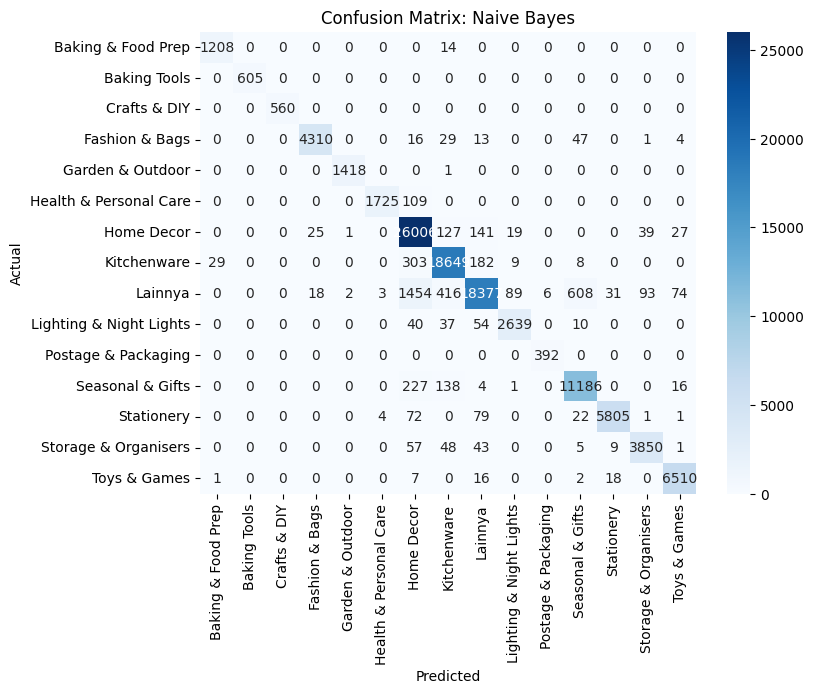

In [23]:
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    conf_mat = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

## Visualisasi Multivariate

<ipython-input-24-1514503389>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Category", y="item_length", palette="Set3")


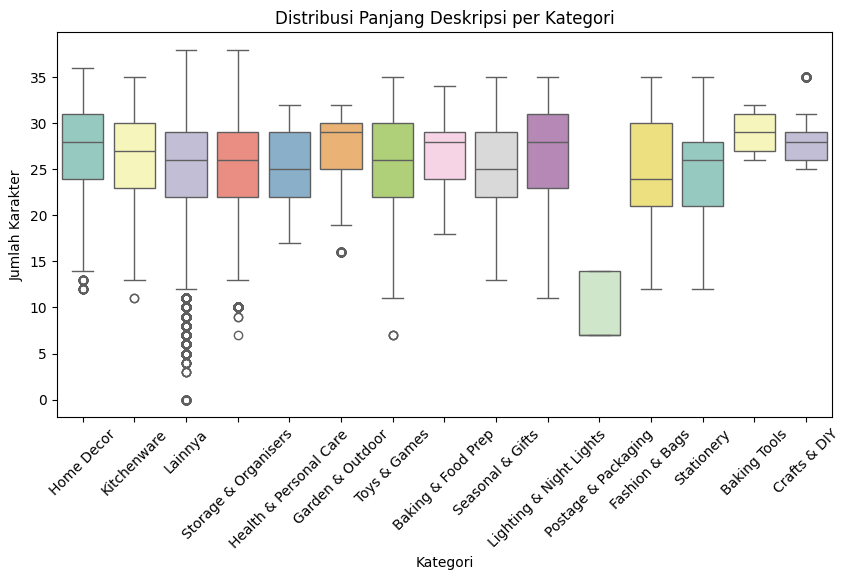

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="Category", y="item_length", palette="Set3")
plt.title("Distribusi Panjang Deskripsi per Kategori")
plt.xticks(rotation=45)
plt.ylabel("Jumlah Karakter")
plt.xlabel("Kategori")
plt.show()

# **Simpan Model & Vectorizer**

In [25]:
joblib.dump(models["Logistic Regression"], "kategori_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
df.to_csv("data_labeled.csv", index=False)

print("Model dan vectorizer berhasil disimpan!")

Model dan vectorizer berhasil disimpan!


In [26]:
!pip freeze > requirements.txt

In [27]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>